<div class="alert alert-block alert-info">
    <b>この章の目的</b>
    <p>ROSのTFを使った座標変換の方法を学習します</p>
</div> 

# TF listener を使った座標の問い合わせ方法

ROSには、座標変換をするTFという便利な仕組みがあります。

TFは、ROSの/tfトピックを使用するのですが、どのROSノードであっても座標変換情報をpublishすることが許されています。publishされた座標変換情報は、各node上で木構造の座標変換情報として統合されます。このTFを受信し統合する仕組みのことをlistenerと呼びます。

TFを利用するために、まずはlistenerを作成します。

In [1]:
import rospy
import tf

rospy.init_node("tf_listener")
listener = tf.TransformListener()

listenerを使うと、様々な座標変換情報にアクセスできるのですが、アクセスするには各座標の「名前」が必要です。

各座標の名前を調べるにはrvizを使うのが便利です。

rvizを立ち上げて、「Add」ボタンを押して「RobotModel」と「TF」を追加します。

「TF」を展開して、「Frames」から興味のある座標名にチェックを入れてその位置を確認しましょう。

その際に「RobotModel」の「Alpha」を0.3程度に設定すると、ロボットの体が半透明になって確認しやすいです。

In [2]:
!import -window RViz* /tmp/screen.png

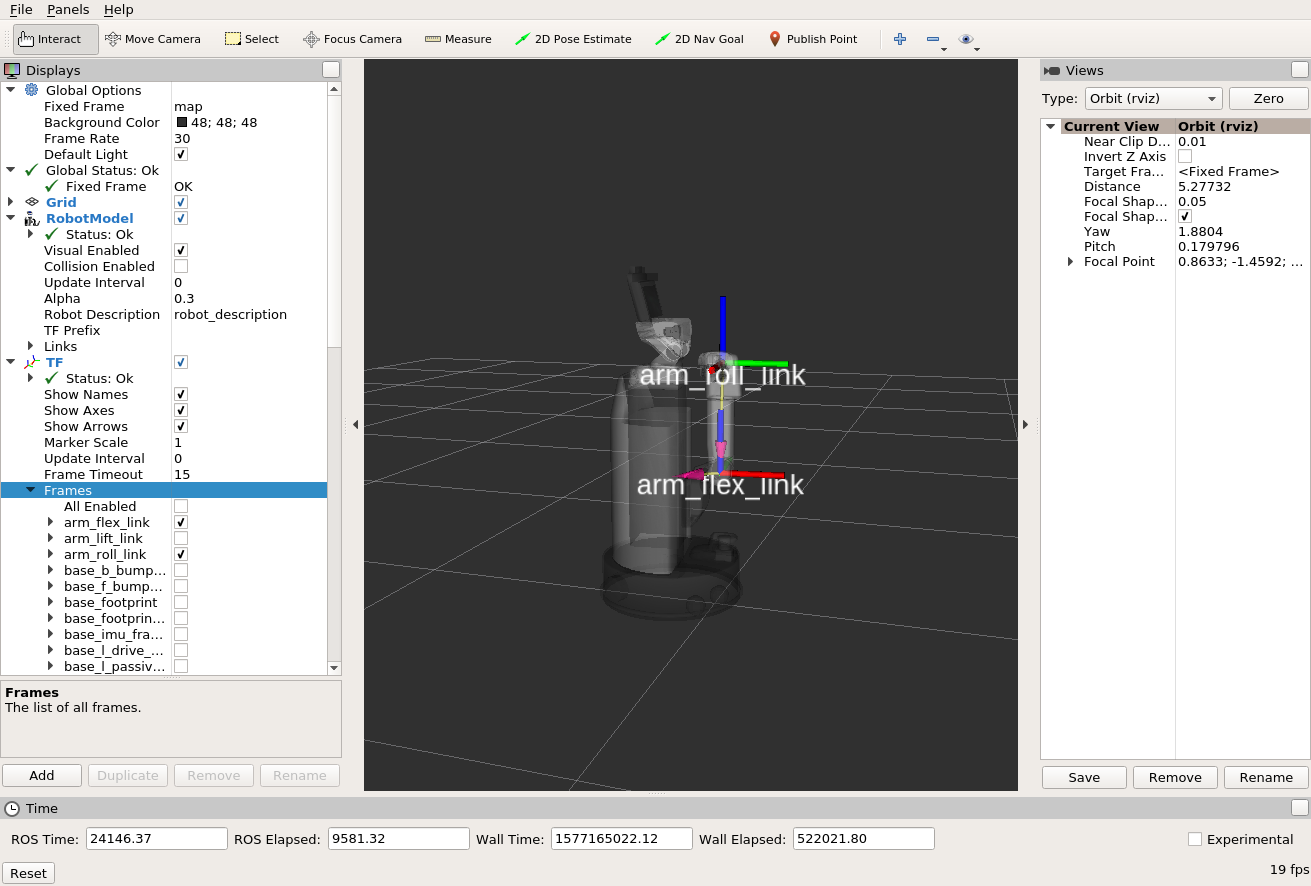

In [3]:
from IPython.display import Image
with open('/tmp/screen.png','rb') as file:
    display(Image(data=file.read()))

試しにarm_flex_linkからarm_roll_linkへの座標変換をTFを使って問い合わせてみましょう。

In [2]:
listener.lookupTransform('arm_flex_link', 'arm_roll_link', rospy.Time(0))

([0.005, 0.0, 0.345], [0.0, 0.0, -0.7068018827818394, 0.7074115481783195])

座標は、(\[x, y, z\], \[x, y, z, w\])の形式で返ってきます（姿勢は四元数=quaternionです）。

ロボットのアームの長さは、約34.5cmであることがわかりました。

# 座標の繰り返し変換

TFは、座標変換を木構造で管理しており、遠く離れた座標同士であっても座標変換を繰り返すことで座標を計算できます。

例えば、ロボットの移動中心座標（base_footprint）からarm_roll_linkへの座標変換を問い合わせると以下の結果が返ってきます。

In [3]:
listener.lookupTransform('base_footprint', 'arm_roll_link', rospy.Time(0))

([0.14600690572130554, 0.078, 0.7349999757778396],
 [-7.073892308702063e-06,
  7.079970364995884e-06,
  -0.7068030649622548,
  0.707410366943966])

ロボットの手首は、現在、地表から約73.5cmの高さにあるようです。

# 座標のpublish

TFでは、どのROSノードでも座標変換をpublishすることが許されています。

試しに私たちも座標変換をpublishしてみましょう。

ここでは、画像認識の結果、頭部カメラ（head_center_camera_frame）の前方40cmの位置にオブジェクト「banana」が検出されたと仮定します。

TFはPythonスクリプトを使ってもpublishできますが、ここではコマンドを使ってpublishしてみます。
以下のコマンドをターミナル上で入力してください。

In [6]:
%%script bash --bg
rosrun tf static_transform_publisher 0 0 0.4 0 0 0 head_center_camera_frame banana 100

Starting job # 3 in a separate thread.


static_transform_publisherは、座標変換を定期的にpublishするコマンドです。

コマンドの引数に「x y z r p y」の形式、または、「x y z qx qy qz qw」の四元数を使った形式で座標間の変換を設定します。

ここでは、「x y z r p y」の形式で、「head_center_camera_frameの前方40cmの位置にbananaがある」という情報をpublishしています
（カメラの座標系では前方がZ軸です）。

publishした情報は、listenerを使って取得できます。

In [7]:
listener.lookupTransform('head_center_camera_frame', 'banana', rospy.Time(0))

([0.0, 0.0, 0.4], [0.0, 0.0, 0.0, 1.0])

publishした座標は、rviz上にも表示されているはずなので、画面を確認してください。

In [17]:
!import -window RViz* /tmp/screen.png

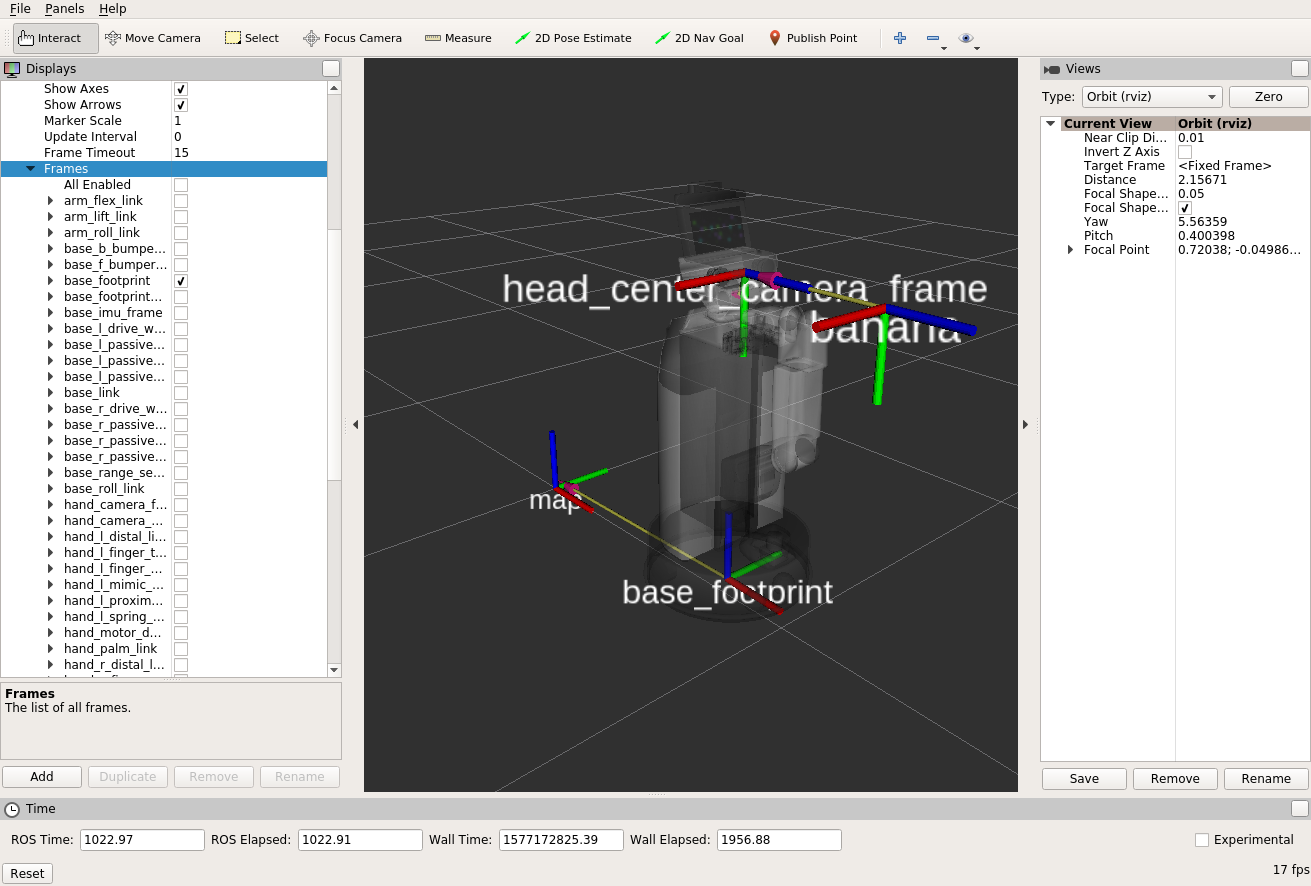

In [18]:
from IPython.display import Image
with open('/tmp/screen.png','rb') as file:
    display(Image(data=file.read()))

座標変換の仕組みも動作しているので、遠く離れた座標との間の変換も計算できます。

例えば、ロボットの移動中心座標から見たbananaの位置は以下の通りです。

In [8]:
listener.lookupTransform('base_footprint', 'banana', rospy.Time(0))

([0.43944134394509193, -5.180856934577405e-06, 0.8384020663240088],
 [-0.4997573926354456,
  0.4997632846316223,
  -0.5002424953519172,
  0.5002365977060458])

自己位置推定が動作している環境では、マップの中心座標が「odom」としてpublishされています。

シミュレーション環境下では、ロボットの自己位置の真値が「map」としてpublishされており、自己位置推定が良好に動作していれば、「mapの座標＝odomの座標」となります。

odom(=map)からbananaへの座標変換は、map->base_footprint->head_center_camera_frame->bananaと変換を繰り返すことで計算可能です。

この計算はTFが自動で行ってくれますので、我々は以下のコマンドだけでbananaの絶対座標を取得できます。

In [9]:
listener.lookupTransform('map', 'banana', rospy.Time(0))

([1.1733380114201242, 0.041303915052646745, 0.8384020620820971],
 [-0.4940034672734702,
  0.5054516481746892,
  -0.505936311140047,
  0.49447715290929334])

# 座標変換の木構造の可視化

TFでは、座標変換は親子のある木構造で管理されています。

「view_frames」コマンドを使うと、その木構造を画像で確認できます。

In [21]:
!rosrun tf view_frames && dot -T png frames.gv -o frames.png

Listening to /tf for 5.000000 seconds
Done Listening
dot - graphviz version 2.38.0 (20140413.2041)

Detected dot version 2.38
frames.pdf generated


画像が大きいのでスクロールして閲覧してください。

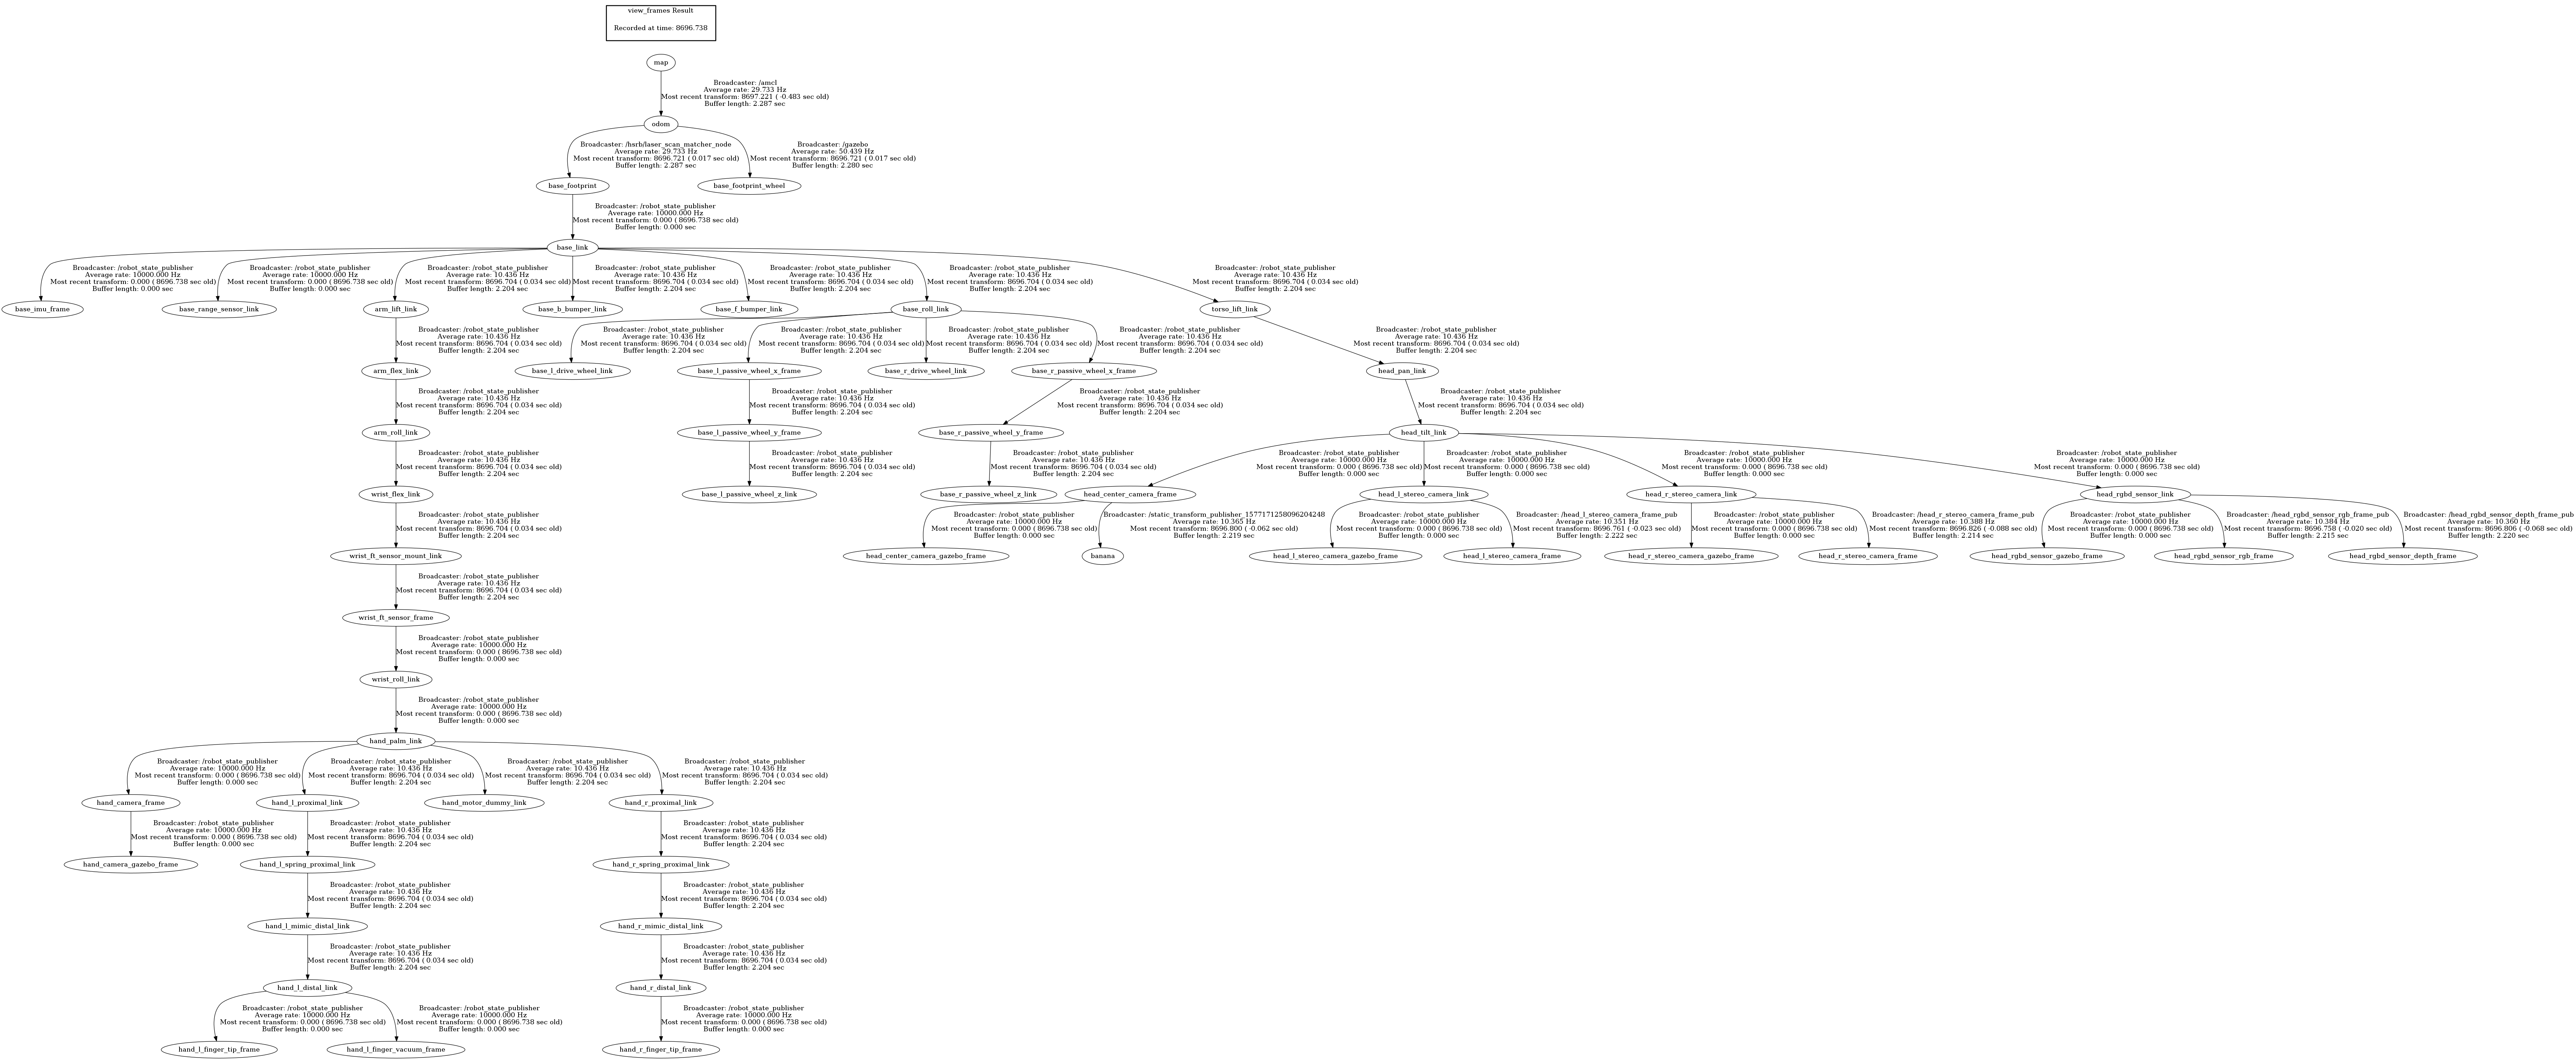

In [23]:
from IPython.display import Image
with open('frames.png','rb') as file:
    display(Image(data=file.read(), unconfined=True))